# Figure 6

In [1]:
from sympy import symbols, exp, solve, logcombine, simplify, Piecewise, lambdify, N, init_printing, Eq
import numpy
from sympy.physics.units import seconds, siemens, volts, farads, amperes, milli, micro, nano, pico, ms, s, kg, meters
from matplotlib import pyplot as plt
import matplotlib
plt.style.use('seaborn-white')
import os
import sys
sys.path.append('../')
from Linearity import Neuron
import lmfit

In [2]:
from IPython.display import display, Markdown, Image

In [3]:
init_printing()

## 6 A Circuit diagram

<img src="Fig_6_a.png" alt="Drawing" style="width: 400px;"/>

## 6 B: Fitting voltage clamp data to get parameters

In [6]:
analysisFile = '/media/sahil/NCBS_Shares_BGStim/patch_data/170530/c1_EI/plots/c1_EI.pkl'
plotDir = os.path.dirname(analysisFile)
neuron = Neuron.load(analysisFile)

$g(t) = \bar{g}\frac{( e^\frac{\delta_{onset} - t }{\tau_{decay}} - e^\frac{\delta_{onset} - t }{\tau_{rise}})}{- \left(\frac{\tau_{rise}}{\tau_{decay}}\right)^{\frac{\tau_{decay}}{\tau_{decay} - \tau_{rise}}} + \left(\frac{\tau_{rise}}{\tau_{decay}}\right)^{\frac{\tau_{rise}}{\tau_{decay} - \tau_{rise}}}}$

In [7]:
def fitFunctionToPSP(time, vector, t_0=0, g_max=0):
    ''' Fits using lmfit '''

    def _doubleExponentialFunction(t, t_0, tOn, tOff, g_max):
        ''' Returns the shape of an EPSP as a double exponential function '''
        tPeak = t_0 + float(((tOff * tOn)/(tOff-tOn)) * numpy.log(tOff/tOn))
        A = 1./(numpy.exp(-(tPeak-t_0)/tOff) - numpy.exp(-(tPeak-t_0)/tOn))
        g = [ g_max * A * (numpy.exp(-(t_point-t_0)/tOff) - numpy.exp(-(t_point-t_0)/tOn)) if  t_point >= t_0 else 0. for t_point in t]
        return numpy.array(g)

    model = lmfit.Model(_doubleExponentialFunction)
    # Fixing values of variables from data
    # Onset time
    if not t_0:
        model.set_param_hint('t_0', value =max(time)/10., min=0., max = max(time))
    else:
        model.set_param_hint('t_0', value = t_0, vary=False)
    # g_max 
    if not g_max:
        model.set_param_hint('g_max', value = max(vector)/10., min = 0., max = max(vector))
    else:
        model.set_param_hint('g_max', value = g_max, vary=False)

    model.set_param_hint('tOn', value =max(time)/5.1 , min = 0., max = max(time))
    model.set_param_hint('t_ratio', value =10., min=1.05)
    model.set_param_hint('tOff', min = 0., expr='tOn*t_ratio')
    model.set_param_hint('t_peak', expr = 't_0 + ((tOff * tOn)/(tOff-tOn)) * log(tOff/tOn)')
    pars = model.make_params()

    result = model.fit(vector, pars, t=time)
    # print (result.fit_report())
    return result

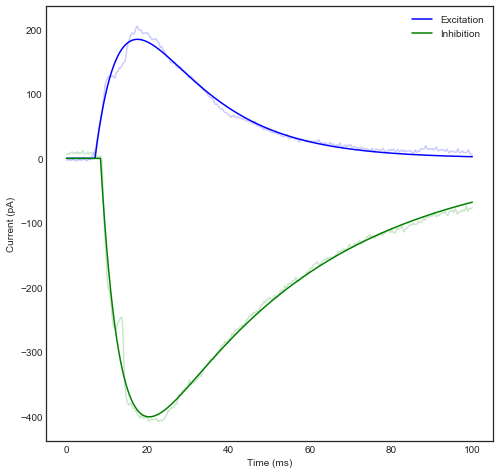

In [8]:
n = {key:value for key,value in neuron}
for numSq in set(n[1]).intersection(set(n[2])):
    for i in set(n[1][numSq].trial).intersection(set(n[2][numSq].trial)):
        if i == 3 and numSq == 7:
            exc = -1e9*n[1][numSq].trial[i].interestWindow
            inh = 1e9*n[2][numSq].trial[i].interestWindow
            time = numpy.arange(len(n[1][numSq].trial[i].interestWindow))*n[1][numSq].trial[i].samplingTime
            exc_fit = fitFunctionToPSP(time, exc)
            inh_fit = fitFunctionToPSP(time, inh)

            f,ax = plt.subplots() 
            ax.plot(time*1e3, exc, alpha=0.2, c='b')
            ax.set_xlabel("Time (ms)")
            ax.set_ylabel("Current (pA)")
            ax.plot(time*1e3, exc_fit.best_fit, '-', label="Excitation", c='b')

            ax.plot(time*1e3, -inh, alpha=0.2, c='g')
            ax.plot(time*1e3, -inh_fit.best_fit, '-', label="Inhibition", c='g')
            plt.legend()
            f.set_figwidth(8)
            f.set_figheight(8)
            plt.show()

In [9]:
samplingRate = 20  # kHz, to get milliseconds
sample_every = 10 # points
timeStep, maxTime = (sample_every*1.)/ samplingRate, 100.  # ms
trange = numpy.arange(
    0., maxTime, timeStep)  # We will always use 100. ms timecourse of PSPs.

In [10]:
#### Range of $g_e$ explored
emax = 4
e_step = 0.5
erange = numpy.arange(0., emax, e_step)
#### Range of proportionality ($P$) between $E$ and $I$
prop_array = numpy.arange(0, 5, 1)

In [11]:
## Setting up the variables, parameters and units for simulation
t, P, e_r, e_d, delta_e, rho_e, g_e, i_r, i_d, delta_i, rho_i, g_i, b, Cm, g_L = symbols(
    't P \\tau_{er} \\tau_{ed} \\delta_e \\rho_e \\bar{g}_e \\tau_{ir} \\tau_{id} \\delta_i \\rho_i \\bar{g}_i \\beta C_m \\bar{g}_L',
    positive=True,
    real=True)
leak_rev, e_rev, i_rev, Vm = symbols(
    'Leak_{rev} Exc_{rev} Inh_{rev} V_m', real=True)
SymbolDict = {
    t: "Time (ms)",
    P: "Proportion of $g_i/g_e$",
    e_r: "Excitatory Rise (ms)",
    e_d: "Excitatory Fall (ms)",
    delta_e: "Excitatory onset time (ms)",
    rho_e: "Excitatory $tau$ ratio (fall/rise)",
    g_e: "Excitatory max conductance",
    i_r: "Inhibitory Rise (ms)",
    i_d: "Inhibitory Fall(ms)",
    delta_i: "Inhibitory onset time(ms)",
    rho_i: "Inhibitory $tau$ ratio (fall/rise)",
    g_i: "Inhibitory max conductance",
    b: "Inhibitory/Excitatory $tau$ rise ratio"
}
unitsDict = {
    's': seconds,
    'exp': exp,
    'S': siemens,
    'V': volts,
    'A': amperes,
    'm': meters,
    'kg': kg
}  # This is for lamdify
nS, pF, mV, pA = nano * siemens, pico * farads, milli * volts, pico*amperes
### Estimates from data and averaging them to get a number
estimateDict = {
    P: (1.9, 2.1),
    e_r: (1.5 * ms, 5 * ms),
    e_d: (8. * ms, 20. * ms),
    delta_e: (0. * ms, 0. * ms),
    rho_e: (2., 7.),
    g_e: (0.02 * nS, 0.25 * nS),
    i_r: (1.5 * ms, 5. * ms),
    i_d: (14. * ms, 60. * ms),
    delta_i: (2. * ms, 4. * ms),
    rho_i: (5., 20.),
    g_i: (0.04 * nS, 0.5 * nS),
    b: (0.5, 5.)
}
averageEstimateDict = {
    key: value[0] + value[1] / 2
    for key, value in estimateDict.items()
}

### Approximating the rest from literature
approximateDict = {
    g_L: 10 * nS,
    e_rev: 0. * mV,
    i_rev: -70. * mV,
    leak_rev: -65. * mV,
    Cm: 100 * pF
}
sourceDict = {
    g_L: "None",
    e_rev: "None",
    i_rev: "None",
    leak_rev: "None",
    Cm: "Neuroelectro.org"
}

| Variable  |  Meaning |  Range |
|---|---|---|
|$t$|Time (ms)|0-100|
|$P$|Proportion of $g_i/g_e$|2-4|
|$\tau_{er}$|Excitatory Rise (ms)|1.5-5|
|$\tau_{ed}$|Excitatory Fall (ms)|8-20|
|$\delta_e$|Excitatory onset time (ms)|0-0|
|$\rho_e$|Excitatory $tau$ ratio (fall/rise)|2-7|
|$\bar{g}_e$|Excitatory max conductance|0.02-0.25|
|$\tau_{ir}$|Inhibitory Rise (ms)|1.5-5|
|$\tau_{id}$|Inhibitory Fall(ms)|14-60|
|$\delta_i$|Inhibitory onset time(ms)|3-15|
|$\rho_i$|Inhibitory $tau$ ratio (fall/rise)|5-20|
|$\bar{g}_i$|Inhibitory max conductance|0.04-0.5|
|$\beta$|Inhibitory/Excitatory $tau$ rise ratio|0.5-5|

| Variable  |  Meaning | Source | Value |
|---|---|---|
|$g_L$|Leak conductance|Undefined| 10 nS |
|$Exc_{rev}$|Excitatory reversal|Undefined| 0 mV|
|$Inh_{rev}$|Inhibitory reversal |Undefined| -70 mV |
|$Leak_{rev}$|Leak reversal |Undefined| -65 mV |
|$C_m$|Membrane capacitance |neuroelectro.org| 100 pF|

---

In [12]:
### Double exponential to explain the net synaptic conductance.
alpha = exp(-(t - delta_e) / e_d) - exp(-(t - delta_e) / e_r)
alpha_prime = alpha.diff(t)
theta_e = solve(alpha_prime, t)  # Time to peak
theta_e = logcombine(theta_e[0])
simplify(theta_e.subs(averageEstimateDict))
alpha_star = simplify(alpha.subs(t, theta_e).doit())

### Finding maximum of the curve and substituting ratio of taus
g_E = Piecewise((0. * nS, t / ms < delta_e / ms), (g_e * (alpha / alpha_star),
                                                   True))
### Final equation for Excitation normalized to be maximum at $g_e$

### Doing the same with inhibition
g_I = g_E.xreplace({
    g_e: g_i,
    rho_e: rho_i,
    e_r: i_r,
    e_d: i_d,
    delta_e: delta_i
})
alpha_I = alpha.xreplace({e_r: i_r, e_d: i_d, delta_e: delta_i})
alpha_star_I = alpha_star.xreplace({e_r: i_r, e_d: i_d})
g_I = Piecewise((0. * nS, t / ms < delta_i / ms),
                (g_i * (alpha_I / alpha_star_I), True))

In [13]:
### Now finding the control peak using difference of these double-exponentials
compartment = Eq((1 / Cm) * (g_E * (Vm - e_rev) + g_I * (Vm - i_rev) + g_L *
                             (Vm - leak_rev)), Vm.diff(t))
Vm_t = solve(compartment, Vm, rational=False, simplify=True)
check_vm_t = Vm_t[0].subs({ i: averageEstimateDict[i] for i in averageEstimateDict if i not in [g_e, g_i, P] }).subs(approximateDict).subs({ g_i: P * g_e })

In [14]:
f = lambdify((g_e, P, t), check_vm_t/mV, (unitsDict, "numpy"))

## 6 C Divisive Inhibition: Inhibition proportional to Excitation, or $g_i = P \times g_e$

In [15]:
di_exc =  [[float(f(e * nS, 0., dt * ms)) for dt in trange] for e in erange]
di_control = {prop: [[float(f(e * nS, prop, dt * ms)) for dt in trange] for e in erange] for prop in prop_array}

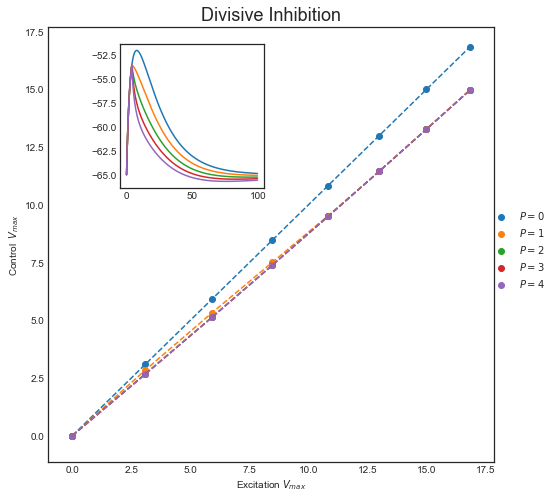

In [16]:
fig, ax = plt.subplots()
handles, labels = [], []
for prop in prop_array:
    v_max, e_max = [], []
    for con_trace,e_t in zip(di_control[prop], di_exc):
        v_max.append(max(con_trace) - float(approximateDict[leak_rev]/mV))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
    handles.append(ax.scatter(e_max, v_max))
    ax.plot(e_max, v_max, '--')
    labels.append("$P= {}$".format(prop))
ax.set_xlabel("Excitation $V_{max}$")
ax.set_ylabel("Control  $V_{max}$")
left, bottom, width, height = [0.25, 0.6, 0.25, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
for prop in prop_array:
    ax2.plot(trange, di_control[prop][5])
#ax2.set_xlabel("Time")
#ax2.set_ylabel("Membrane potential (mV)")
fig.legend(handles, labels, loc ='center right')
fig.set_figheight(8)
fig.set_figwidth(8)
ax.set_title("Divisive Inhibition", fontsize=18)
plt.show()

In [17]:
print ( "Constant $delta_i$ was {:.1f} ms".format(averageEstimateDict[delta_i]/ms))

Constant $delta_i$ was 4.0 ms


6 DEF: Divisive Normalization: Inhibition proportional to Excitation, or $g_i = P \times g_e$ and $\delta_i$ inversely proportional to $g_e$

## 6 D Changing $\delta_i$ = $\delta_{min} + me^{-k\times{g_e}}$

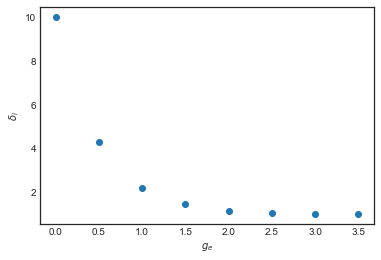

In [18]:
d = lambda minDelay,k,e: minDelay + m*exp(-(k*e))
nS = nano*siemens
k, m, minDelay = 2/nS, 9*ms, 1.*ms
fig,ax = plt.subplots()
ax.scatter(erange, [d(minDelay,k,e*nS)/ms for e in erange])
plt.xlabel("$g_e$")
plt.ylabel("$\\delta_i$")
fig.set_figwidth(8)
fig.set_figheight(8)
plt.show()

In [19]:
check_vm = simplify(Vm_t[0].subs({i:averageEstimateDict[i] for i in averageEstimateDict if i not in [g_e, g_i, delta_i]}).subs(approximateDict).subs({g_i: P*g_e, delta_i: d(minDelay,k,g_e)}).evalf())
f = lambdify((g_e, P, t), check_vm/mV, (unitsDict, "numpy"))

In [20]:
dn_exc =  [[float(f(e * nS, 0., dt * ms)) for dt in trange] for e in erange]
dn_control = {prop: [[float(f(e * nS, prop, dt * ms)) for dt in trange] for e in erange] for prop in prop_array}

## 6 E Divisive Normalization 

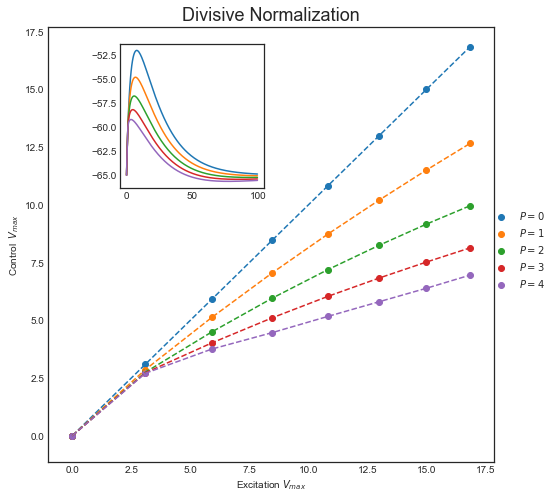

In [21]:
fig, ax = plt.subplots()
handles, labels = [], []
for prop in prop_array:
    v_max, e_max = [], []
    for con_trace,e_t in zip(dn_control[prop], dn_exc):
        v_max.append(max(con_trace) - float(approximateDict[leak_rev]/mV))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
    handles.append(ax.scatter(e_max, v_max))
    ax.plot(e_max, v_max, '--')
    labels.append("$P= {}$".format(prop))
ax.set_xlabel("Excitation $V_{max}$")
ax.set_ylabel("Control  $V_{max}$")
left, bottom, width, height = [0.25, 0.6, 0.25, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
for prop in prop_array:
    ax2.plot(trange, dn_control[prop][5])
#ax2.set_xlabel("Time")
#ax2.set_ylabel("Membrane potential (mV)")
fig.legend(handles, labels, loc ='center right')
fig.set_figheight(8)
fig.set_figwidth(8)
ax.set_title("Divisive Normalization", fontsize=18)
plt.show()

## 5 B Model subtraction scheme

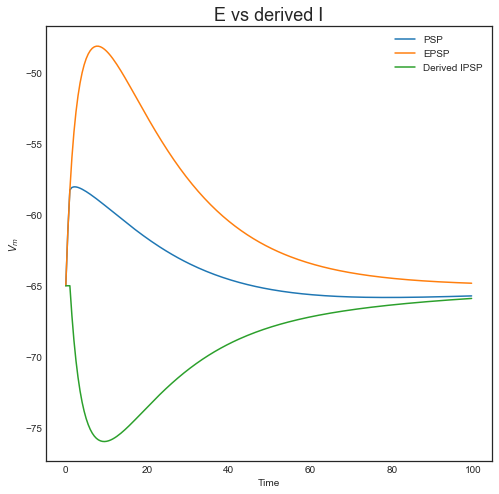

In [30]:
fig, ax = plt.subplots()
handles, labels = [], []
prop = 4

i_max, e_max = [], []
trace_c, trace_e = numpy.array(dn_control[prop][-1]), numpy.array(dn_exc[-1])
ax.plot(trange, trace_c, label="PSP")
ax.plot(trange, trace_e, label="EPSP")
trace_i =  float(approximateDict[leak_rev]/mV) + (trace_c - trace_e)
ax.plot(trange, trace_i, label="Derived IPSP")
ax.set_xlabel("Time")
ax.set_ylabel("$V_m$")
fig.set_figheight(8)
fig.set_figwidth(8)
ax.set_title("E vs derived I", fontsize=18)
plt.legend()
plt.show()

## 6 F Excitation - Derived Inhibition plot

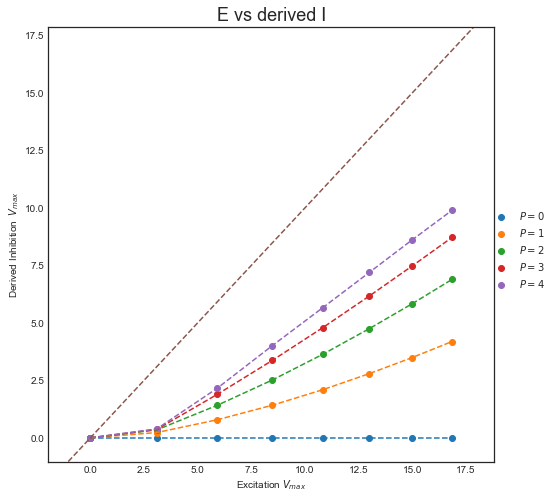

In [31]:
fig, ax = plt.subplots()
handles, labels = [], []
for prop in prop_array:
    i_max, e_max = [], []
    for con_trace,e_t in zip(dn_control[prop], dn_exc):
        i_max.append(max(e_t) - max(con_trace))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
    handles.append(ax.scatter(e_max, i_max))
    ax.plot(e_max, i_max, '--')
    labels.append("$P= {}$".format(prop))
ax.set_xlabel("Excitation $V_{max}$")
ax.set_ylabel("Derived Inhibition  $V_{max}$")
xlim = ax.get_xlim()
ax.set_ylim (xlim)
ax.plot(xlim, xlim, '--')
fig.legend(handles, labels, loc ='center right')
fig.set_figheight(8)
fig.set_figwidth(8)
ax.set_title("E vs derived I", fontsize=18)
plt.show()

## 6 G Time to peak

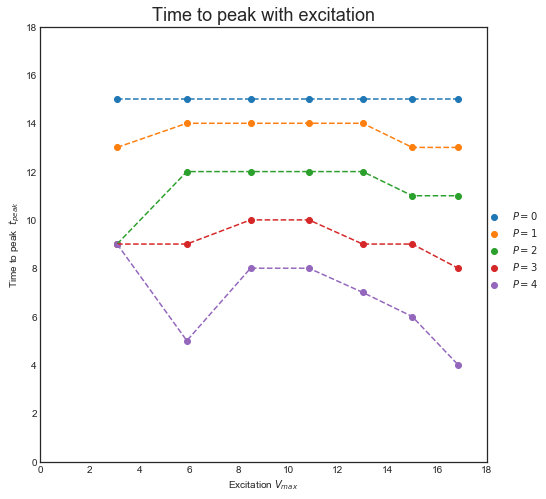

In [32]:
fig, ax = plt.subplots()
handles, labels = [], []
for prop in prop_array:
    ttp, e_max = [], []
    for con_trace,e_t in zip(dn_control[prop], dn_exc):
        ttp.append(numpy.argmax(con_trace))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
    handles.append(ax.scatter(e_max[1:], ttp[1:]))
    ax.plot(e_max[1:], ttp[1:], '--')
    labels.append("$P= {}$".format(prop))
ax.set_xlabel("Excitation $V_{max}$")
ax.set_ylabel("Time to peak  $t_{peak}$")
ax.set_xlim(0,18)
ax.set_ylim(0,18)
fig.legend(handles, labels, loc ='center right')
fig.set_figheight(8)
fig.set_figwidth(8)
ax.set_title("Time to peak with excitation", fontsize=18)
plt.show()

## 6 H Permutation of P

In [206]:
check_vm = simplify(Vm_t[0].subs({i:averageEstimateDict[i] for i in averageEstimateDict if i not in [g_e, g_i, delta_i]}).subs(approximateDict).subs({delta_i: d(minDelay,k,g_e)}).evalf())
f = lambdify((g_e, g_i, t), check_vm/mV, (unitsDict, "numpy"))

In [208]:
p_perm_dn_exc =  [[float(f(e * nS, 0., dt * ms)) for dt in trange] for e in erange]
p_perm_dn_control = {prop: [[float(f(e * nS, i * nS, dt * ms)) for dt in trange] for (e,i) in zip(erange, numpy.random.permutation(erange*prop))] for prop in prop_array}

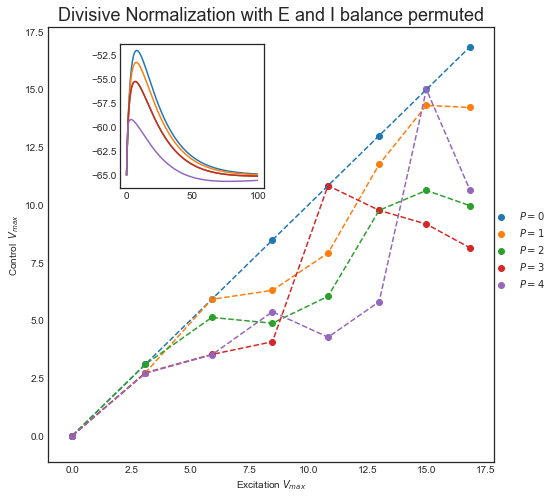

In [209]:
fig, ax = plt.subplots()
handles, labels = [], []
for prop in prop_array:
    v_max, e_max = [], []
    for con_trace,e_t in zip(p_perm_dn_control[prop], p_perm_dn_exc):
        v_max.append(max(con_trace) - float(approximateDict[leak_rev]/mV))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
    handles.append(ax.scatter(e_max, v_max))
    ax.plot(e_max, v_max, '--')
    labels.append("$P= {}$".format(prop))
ax.set_xlabel("Excitation $V_{max}$")
ax.set_ylabel("Control  $V_{max}$")
left, bottom, width, height = [0.25, 0.6, 0.25, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
for prop in prop_array:
    ax2.plot(trange, p_perm_dn_control[prop][5])
#ax2.set_xlabel("Time")
#ax2.set_ylabel("Membrane potential (mV)")
fig.legend(handles, labels, loc ='center right')
fig.set_figheight(8)
fig.set_figwidth(8)
ax.set_title("Divisive Normalization with E and I balance permuted", fontsize=18)
plt.show()

## 6 I Permutation of $\delta_i$

In [210]:
check_vm = simplify(Vm_t[0].subs({i:averageEstimateDict[i] for i in averageEstimateDict if i not in [g_e, g_i, delta_i]}).subs(approximateDict).subs({g_i: P*g_e}).evalf())
f = lambdify((g_e, P, delta_i, t), check_vm/mV, (unitsDict, "numpy"))

In [211]:
d_perm_dn_exc =  [[float(f(e * nS, 0., d(minDelay,k, e* nS), dt * ms)) for dt in trange] for e in erange]
d_perm_dn_control = {prop: [[float(f(e * nS, prop, delay, dt * ms)) for dt in trange] for e,delay in zip(erange, numpy.random.permutation([d(minDelay,k, e* nS) for e in erange])) ] for prop in prop_array}

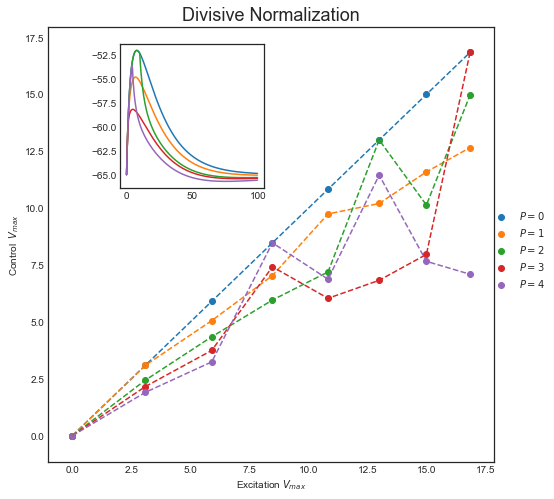

In [212]:
fig, ax = plt.subplots()
handles, labels = [], []
for prop in prop_array:
    v_max, e_max = [], []
    for con_trace,e_t in zip(d_perm_dn_control[prop], d_perm_dn_exc):
        v_max.append(max(con_trace) - float(approximateDict[leak_rev]/mV))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
    handles.append(ax.scatter(e_max, v_max))
    ax.plot(e_max, v_max, '--')
    labels.append("$P= {}$".format(prop))
ax.set_xlabel("Excitation $V_{max}$")
ax.set_ylabel("Control  $V_{max}$")
left, bottom, width, height = [0.25, 0.6, 0.25, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
for prop in prop_array:
    ax2.plot(trange, d_perm_dn_control[prop][5])
fig.legend(handles, labels, loc ='center right')
fig.set_figheight(8)
fig.set_figwidth(8)
ax.set_title("Divisive Normalization", fontsize=18)
plt.show()

## 6 J Phase plot Divisive Normalization

In [224]:
import lmfit
def DN_model(x,a=1):
    # Divisive normalization model
    #return x - a*(x**2)/(b+x)
    return x/(a*x+1)
DN_Model = lmfit.Model(DN_model)

In [225]:
check_vm = simplify(Vm_t[0].subs({i:averageEstimateDict[i] for i in averageEstimateDict if i not in [g_e, g_i, delta_i]}).subs(approximateDict).subs({g_i: P*g_e}).evalf())
f = lambdify((g_e, P, delta_i, t), check_vm/mV, (unitsDict, "numpy"))

In [230]:
phase_dn_control = {}
phase_dn_exc = {}
prop_array = numpy.logspace(-1,1,7)
k_array = numpy.logspace(-1,1,7)
for k in k_array:
    phase_dn_exc[k] = [[float(f(e * nS, 0., d(minDelay,k/nS, e* nS), dt * ms)) for dt in trange] for e in erange]
    phase_dn_control[k] = {prop: [[float(f(e * nS, prop, delay, dt * ms)) for dt in trange] for e,delay in zip(erange, [d(minDelay,k/nS, e* nS) for e in erange]) ] for prop in prop_array}

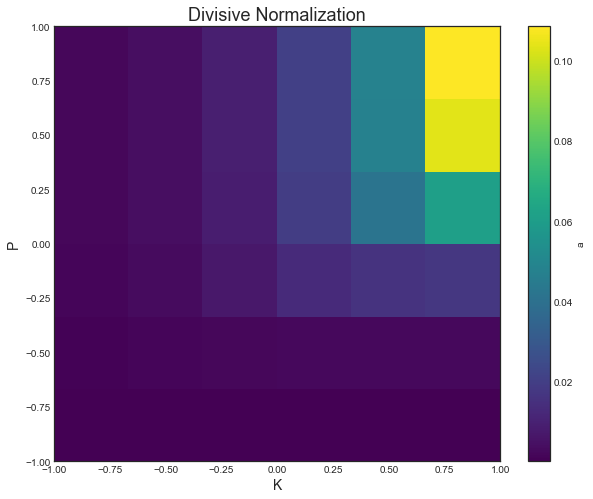

In [277]:
fig, ax = plt.subplots()
phaseMat = numpy.zeros((len(k_array),len(prop_array)))
for ind1, k in enumerate(k_array):
    for ind2, prop in enumerate(prop_array):
        v_max, e_max = [], []
        for con_trace,e_t in zip(phase_dn_control[k][prop], phase_dn_exc[k]):
            v_max.append(max(con_trace) - float(approximateDict[leak_rev]/mV))
            e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
        X, y = e_max, v_max
        DN_pars = DN_Model.make_params()
        DN_result = DN_Model.fit(y, DN_pars, x=X)
        phaseMat[ind1][ind2] = DN_result.params['a']
#         print(DN_result.fit_report())
fig.set_figheight(8)
fig.set_figwidth(10)

x,y = numpy.meshgrid(numpy.linspace(-1,1,7),numpy.linspace(-1,1,7))
heatmap = ax.pcolor(x,y, phaseMat, cmap =matplotlib.cm.viridis)

# ax.xaxis.set(ticklabels=[str(j) for j in k_array])
# ax.yaxis.set(ticklabels=[str(j) for j in prop_array])

# ax.axis([int(k_array.min()),int(k_array.max()),int(prop_array.min()),int(prop_array.max())])

ax.set_xlabel("K", fontsize=14)
ax.set_ylabel("P", fontsize=14)
ax.set_title("Divisive Normalization", fontsize=18)
plt.colorbar(heatmap, label = "a")
plt.show()

In [1]:
# for ind1, k in enumerate(k_array):
#     for ind2, prop in enumerate(prop_array):
#         v_max, e_max = [], []
#         for con_trace,e_t in zip(phase_dn_control[k][prop], phase_dn_exc[k]):
#             v_max.append(max(con_trace) - float(approximateDict[leak_rev]/mV))
#             e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
#         X, y = e_max, v_max
#         DN_pars = DN_Model.make_params()
#         DN_result = DN_Model.fit(y, DN_pars, x=X)
#         print (k, prop)
#         print(DN_result.fit_report())
#         f,ax = plt.subplots()
#         DN_result.plot_fit(ax)
#         plt.show()

## 6 K $\delta_i$ as a function of $g_e$

In [2]:
# n = {key:value for key,value in neuron}
# max_exc = []
# delay = []
# for numSq in set(n[1]).intersection(set(n[2])):
#     for coord in set(n[1][numSq].coordwise).intersection(set(n[2][numSq].coordwise)):
#         exc_fit, inh_fit = [], []
#         for trial in n[1][numSq].coordwise[coord].trials:
#             exc = -1e9*trial.interestWindow
#             time = numpy.arange(len(trial.interestWindow))*trial.samplingTime
#             exc_fit.append(fitFunctionToPSP(time, exc))
#         for i in n[2][numSq].coordwise[coord].trials:
#             inh = 1e9*trial.interestWindow
#             time = numpy.arange(len(trial.interestWindow))*trial.samplingTime
#             inh_fit.append(fitFunctionToPSP(time, inh))
#         max_exc.append(numpy.average([res.params['g_max'] for res in exc_fit]))
#         delay.append(numpy.average([res.params['t_0'] for res in inh_fit]) - numpy.average([res.params['t_0'] for res in exc_fit]))

In [3]:
# fig, ax = plt.subplots()
# ax.scatter(max_exc, delay)
# ax.set_xlabel('Excitation max')
# ax.set_ylabel('$\delta_i$')
# plt.show()